Link to unprocessed dataset: http://web.archive.org/web/20130924222653/http://iec.csic.es/dataset

# TextCNN for Web Application Attacks Detection

# Raw data preprocessing, LOG file to CSV

Here we needed to preprocess the raw data from the LOG file to CSV format

In [ ]:
import pandas as pd
from urllib.parse import unquote

# Define the files and their corresponding classifications
files_with_classification = [
    ('normalTrafficTest.txt', 0),
    ('normalTrafficTraining.txt', 0),
    ('anomalousTrafficTest.txt', 1)
]

# Initialize an empty list to store all processed requests
all_requests = []

# Function to parse HTTP log into individual requests
def parse_http_log(log):
    lines = log.strip().splitlines()
    requests = []
    current_request = []
    for line in lines:
        # Check for the start of a new request
        if line.startswith(('GET ', 'POST ', 'PUT ', 'DELETE ', 'HEAD ', 'OPTIONS ', 'TRACE ', 'CONNECT ')):
            if current_request:
                requests.append('\n'.join(current_request))
                current_request = []
        current_request.append(line)
    if current_request:
        requests.append('\n'.join(current_request))
    return requests

# Function to process each request
def process_request(request, classification):
    lines = request.strip().split('\n')

    # Ensure the first line has at least three parts
    if len(lines) == 0 or len(lines[0].split()) < 3:
        # Skip invalid request lines
        return None

    method, url, _ = lines[0].split(" ", 2)
    headers = {}
    body_lines = []
    is_body = False
    for line in lines[1:]:
        if line.strip() == '':
            is_body = True
            continue
        if is_body:
            body_lines.append(line)
        elif ": " in line:
            key, value = line.split(": ", 1)
            headers[key.strip().lower()] = value.strip()
        else:
            # Ignore any lines that are neither headers nor body
            pass

    # Combine body lines into a single string
    body = '\n'.join(body_lines).strip()

    # Build the request dictionary
    request_dict = {
        "classification": classification,
        "Method": method,
        "User-Agent": headers.get("user-agent", ""),
        "Pragma": headers.get("pragma", ""),
        "Cache-Control": headers.get("cache-control", ""),
        "Accept": headers.get("accept", ""),
        "Accept-encoding": headers.get("accept-encoding", ""),
        "Accept-charset": headers.get("accept-charset", ""),
        "language": headers.get("accept-language", ""),
        "host": headers.get("host", ""),
        "cookie": headers.get("cookie", ""),
        "content-type": headers.get("content-type", ""),
        "connection": headers.get("connection", ""),
        "length": headers.get("content-length", "0"),
        "content": body,
        "URL": url,
    }

    return request_dict

# Process each file
for filename, classification in files_with_classification:
    count_processed = 0
    with open(filename, 'r', encoding='utf-8', errors='ignore') as file:
        http_log = file.read()
        requests = parse_http_log(http_log)
        for req in requests:
            processed_req = process_request(req, classification)
            if processed_req:
                all_requests.append(processed_req)
                count_processed += 1
        print(f"Processed {count_processed} requests from {filename}")

# Create a pandas DataFrame
df = pd.DataFrame(all_requests, columns=[
    "classification", "Method", "User-Agent", "Pragma", "Cache-Control",
    "Accept", "Accept-encoding", "Accept-charset", "language", "host",
    "cookie", "content-type", "connection", "length", "content", "URL"
])

# covert the dataframe to a csv file
df.to_csv('http_requests.csv', index=False)
print("CSV file created successfully.")

Processed 36000 requests from normalTrafficTest.txt
Processed 36000 requests from normalTrafficTraining.txt
Processed 25065 requests from anomalousTrafficTest.txt
CSV file created successfully.


## Import data from CSV preprocessed CSV

We can now import the preprocessed CSV file

In [ ]:
import pandas as pd
import urllib.parse

file_path = "http_requests.csv"
data = pd.read_csv(file_path)

# Exploratory Data Analysis (EDA)

## Label count

We first start of by checking the distribution of the labels in the dataset

In [ ]:
# How many datapoints for each classification label
print(data['classification'].value_counts())

classification
0    72000
1    25065
Name: count, dtype: int64


It looks like there is a bit of class imbalance in the dataset, but it is not too severe

## Check for missing values

We check for missing values in the dataset

In [ ]:
# Check for missing values in the entire dataset
print(data.isnull().sum())

classification         0
Method                 0
User-Agent             0
Pragma                 0
Cache-Control          0
Accept               397
Accept-encoding        0
Accept-charset         0
language               0
host                   0
cookie                 0
content-type       71088
connection             0
length                 0
content            71088
URL                    0
dtype: int64


As it is expected to have missing values in the entries, Accept, content-type and content length columns, we will not drop them

## A typical entry

We take a look at a typical entry in the dataset

In [ ]:
pd.set_option('display.max_colwidth', None)
data.iloc[2]

classification                                                                                                       0
Method                                                                                                            POST
User-Agent                                     Mozilla/5.0 (compatible; Konqueror/3.5; Linux) KHTML/3.5.8 (like Gecko)
Pragma                                                                                                        no-cache
Cache-Control                                                                                                 no-cache
Accept             text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,*/*;q=0.5
Accept-encoding                                                                       x-gzip, x-deflate, gzip, deflate
Accept-charset                                                                             utf-8, utf-8;q=0.5, *;q=0.5
language                                        

Here we see a benign entry of a post request with content that also has some URL encoded data

## Showcasing decoded malicious requests

We want to see what a decoded malicious request looks like

In [ ]:
from urllib.parse import unquote
EDA_data = data.copy()
EDA_data['URL_Content'] = EDA_data['URL'] + EDA_data['content'].fillna('')

# show me a url that contain "precio=2293&b1=confirmar"
mal_url = EDA_data[EDA_data['URL_Content'].apply(lambda x: "http://localhost:8080/tienda1/publico/entrar.jsp?errorMsg=Credenciales+incorrectasbob" in x)].iloc[0]['URL_Content']
mal_url

'http://localhost:8080/tienda1/publico/entrar.jsp?errorMsg=Credenciales+incorrectasbob%2540%253CSCRipt%253Ealert%2528Paros%2529%253C%252FscrIPT%253E.parosproxy.org'

First we see an unreadable malicious request

In [ ]:
# decode mal_url two times and then lowercase it
unquote(mal_url), unquote(unquote(mal_url)), unquote(unquote(mal_url)).lower()

('http://localhost:8080/tienda1/publico/entrar.jsp?errorMsg=Credenciales+incorrectasbob%40%3CSCRipt%3Ealert%28Paros%29%3C%2FscrIPT%3E.parosproxy.org',
 'http://localhost:8080/tienda1/publico/entrar.jsp?errorMsg=Credenciales+incorrectasbob@<SCRipt>alert(Paros)</scrIPT>.parosproxy.org',
 'http://localhost:8080/tienda1/publico/entrar.jsp?errormsg=credenciales+incorrectasbob@<script>alert(paros)</script>.parosproxy.org')

We see that when we decode the malicious request, it is still unreadable. But after a second decoding and lowering the case, we can see that the request is a SQL injection attack

# Data Preprocessing

## Decode 'content' and 'URL'

We decode the 'content' and 'URL' columns. We also keep a count of how many times each url was decoded in a column called 'decoding_counts'. This is used as a statistical feature later on in the model.

In [ ]:
# Define a function to decode text with multiple layers of encoding
def decode_text(text):
    if pd.isnull(text):
        return text, 0  # If the text is NaN, return as is
    decoded_text = text
    decode_count = 0
    while True:
        try:
            # Decode the text using latin1 encoding
            temp_text = urllib.parse.unquote(decoded_text, encoding='latin1')
            if temp_text == decoded_text:  # Break if no further decoding is possible
                break
            decoded_text = temp_text
            decode_count += 1
        except:
            break
    return decoded_text, decode_count

# Apply decoding to the 'URL' and 'content' columns
data['URL'], data['URL_decode_count'] = zip(*data['URL'].apply(decode_text))
data['URL'] = data['URL'].str.lower() #lowercase
data['content'] = data['content'].str.lower() #lowercase
data['content'], data['CONTENT_decode_count'] = zip(*data['content'].apply(decode_text))
# add the two count into one column called 'decode_count', and drop the two columns
data['decoding_counts'] = data['URL_decode_count'] + data['CONTENT_decode_count']
data.drop(columns=['URL_decode_count', 'CONTENT_decode_count'], inplace=True)

We can see that we now have decoded the 'content' and 'URL' columns

In [ ]:
data.head(3)

,classification,Method,User-Agent,Pragma,Cache-Control,Accept,Accept-encoding,Accept-charset,language,host,cookie,content-type,connection,length,content,URL,decoding_counts
0,0,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux) KHTML/3.5.8 (like Gecko),no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,*/*;q=0.5","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=EA414B3E327DED6875848530C864BD8F,NaN,close,0,NaN,http://localhost:8080/tienda1/index.jsp,0
1,0,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux) KHTML/3.5.8 (like Gecko),no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,*/*;q=0.5","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=54E25FF4B7F0E4E855B112F882E9EEA5,NaN,close,0,NaN,http://localhost:8080/tienda1/publico/anadir.jsp?id=1&nombre=jamón+ibérico&precio=39&cantidad=41&b1=añadir+al+carrito,1
2,0,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux) KHTML/3.5.8 (like Gecko),no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml,text/html;q=0.9,text/plain;q=0.8,image/png,*/*;q=0.5","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=788887A0F479749C4CEEA1E268B4A501,application/x-www-form-urlencoded,close,74,id=1&nombre=jamón+ibérico&precio=39&cantidad=41&b1=añadir+al+carrito,http://localhost:8080/tienda1/publico/anadir.jsp,1


### Make sure all urls are decoded

We make sure that all URLs are decoded

In [ ]:
# Check for % in url
pd.set_option('display.max_colwidth', None)
print(data[data['URL'].str.contains('%')][['URL']].head(2))

                                                                                                                                                                                       URL
72000  http://localhost:8080/tienda1/publico/anadir.jsp?id=2&nombre=jamón+ibérico&precio=85&cantidad=';+drop+table+usuarios;+select+*+from+datos+where+nombre+like+'%&b1=añadir+al+carrito
72167        http://localhost:8080/tienda1/publico/autenticar.jsp?modo=entrar';+drop+table+usuarios;+select+*+from+datos+where+nombre+like+'%&login=jeanes&pwd=dó712&remember=on&b1=entrar


We see that some URLs are not decoded, but these specific cases are errors and therefore not decodable

## Tokenization of 'URL' and 'content'

We can now tokenize the 'URL' and 'content' columns and append them together for POST requests

In [ ]:
import re

def split_into_list(input_str):
    if pd.isna(input_str):  # Handle NaN values
        return []
    # Split based on non-alphanumeric characters, keeping those characters as separate items
    return re.findall(r'[A-Za-z0-9]+|[^A-Za-z0-9]', input_str)

data['URL'] = data['URL'].apply(split_into_list)
data['content'] = data['content'].apply(split_into_list)

pd.set_option('display.max_colwidth', None)

# append 'content' to 'URL' if POST method
data['URL'] = data.apply(lambda row: row['URL'] + row['content'] if row['Method'] == 'POST' else row['URL'], axis=1)
data[['URL', 'content', 'classification']].head(5)  # Replace 'x' and 'y' with your column names

,URL,content,classification
0,"[http, :, /, /, localhost, :, 8080, /, tienda1, /, index, ., jsp]",[],0
1,"[http, :, /, /, localhost, :, 8080, /, tienda1, /, publico, /, anadir, ., jsp, ?, id, =, 1, &, nombre, =, jam, ó, n, +, ib, é, rico, &, precio, =, 39, &, cantidad, =, 41, &, b1, =, a, ñ, adir, +, al, +, carrito]",[],0
2,"[http, :, /, /, localhost, :, 8080, /, tienda1, /, publico, /, anadir, ., jsp, id, =, 1, &, nombre, =, jam, ó, n, +, ib, é, rico, &, precio, =, 39, &, cantidad, =, 41, &, b1, =, a, ñ, adir, +, al, +, carrito]","[id, =, 1, &, nombre, =, jam, ó, n, +, ib, é, rico, &, precio, =, 39, &, cantidad, =, 41, &, b1, =, a, ñ, adir, +, al, +, carrito]",0
3,"[http, :, /, /, localhost, :, 8080, /, tienda1, /, publico, /, autenticar, ., jsp, ?, modo, =, entrar, &, login, =, caria, &, pwd, =, egipciaca, &, remember, =, off, &, b1, =, entrar]",[],0
4,"[http, :, /, /, localhost, :, 8080, /, tienda1, /, publico, /, autenticar, ., jsp, modo, =, entrar, &, login, =, caria, &, pwd, =, egipciaca, &, remember, =, off, &, b1, =, entrar]","[modo, =, entrar, &, login, =, caria, &, pwd, =, egipciaca, &, remember, =, off, &, b1, =, entrar]",0


## Remove duplicates

We can then remove duplicates from the dataset, this is done by removing entries that have the same 'URL', which now for POST requests is the 'URL' and 'content' columns appended together

In [ ]:
num_rows_before = data.shape[0]
print("Number of rows before :", num_rows_before)
data = data.drop_duplicates(subset=['URL']).reset_index(drop=True)
num_rows_after = data.shape[0]
print("Number of rows after :", num_rows_after)

Number of rows before : 97065
Number of rows after : 33839


# Split into train, validation and test sets

We can then split the dataset into train, validation and test sets, with a 80/10/10 split

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'data' is your DataFrame
# Split data into training (80%), validation (10%), and testing (10%)
def train_validation_test_split(data, train_size=0.8, val_size=0.1, random_state=42):
    # Split into training and remaining (validation + test) sets
    train_data, remaining_data = train_test_split(data, test_size=(1 - train_size), random_state=random_state, stratify=data['classification'])
    # Calculate the validation size relative to the remaining data
    val_relative_size = val_size / (1 - train_size)
    # Split the remaining data into validation and test sets
    val_data, test_data = train_test_split(remaining_data, test_size=1 - val_relative_size, random_state=random_state, stratify=remaining_data['classification'])
    return train_data.reset_index(drop=True), val_data.reset_index(drop=True), test_data.reset_index(drop=True)

# Perform the split
train_data, val_data, test_data = train_validation_test_split(data)

# Print dataset sizes
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Training set size: 27071
Validation set size: 3384
Test set size: 3384


# Skip gram

We can then create our Word2vec word embeddings using the skip gram model on the training set, so we avoid data leakage and don't end up getting a higher accuracy than we should

In [ ]:
from gensim.models import Word2Vec

# Prepare sentences (tokenized URLs) from the training data
train_sentences = train_data['URL'].tolist()

# Train Word2Vec model on training data only
def train_word2vec(sentences, embedding_dim=128):
    model = Word2Vec(sentences=sentences, vector_size=embedding_dim, window=5, min_count=1, sg=1, workers=1, seed=2)
    return model

# Train the embedding model
embedding_dim = 128
word2vec_model = train_word2vec(train_sentences, embedding_dim)

# Try with random word ("example")
print(word2vec_model.wv['example'])

[-1.0160935  -0.14497495 -1.0202705   0.654341   -0.61938596  0.58165944
 -0.5588342  -1.6019428   0.7448447  -0.9451276  -0.17454062  0.04071081
 -0.33959517  0.93060523 -0.01346079  0.24061143 -1.0377454   0.63527495
 -0.48189145  0.44444275  0.0531121  -0.5722121  -0.28755713 -0.5109383
  1.1035836  -0.37869146 -0.60559094 -0.8811419   0.7629005   0.8907694
  0.09930313  0.07626583 -0.04243743 -0.49923202  0.56322306 -1.0092188
 -0.2603358   0.33858293 -0.38865447  0.37236965 -0.78926176 -0.65133405
 -0.6028094   0.79057866 -0.06520203 -0.45260182 -0.2643303  -0.7881262
 -0.13966185 -0.35109442  0.1136246   0.2478398  -0.386656    0.41810927
  0.6532311   0.11314034  0.29130134 -0.49595177 -0.82632923 -0.06001428
 -0.20699179 -0.05778765  0.3107675  -0.4857353  -1.8741084   0.41035622
  0.04738929  0.02394866 -0.29655367  0.09184025  0.33432165 -0.53323376
 -0.6728489   0.6401141  -0.75247586  0.11517897  0.33702078 -0.85042936
 -0.61105865  0.7819193   0.02658508  0.90102243  0.469

Here we see a simple example of how a word embedding looks like

## t-SNE visualization

To visualize the word embeddings, we can use t-SNE. Below we see a t-SNE visualization of 20 different words from the training set.

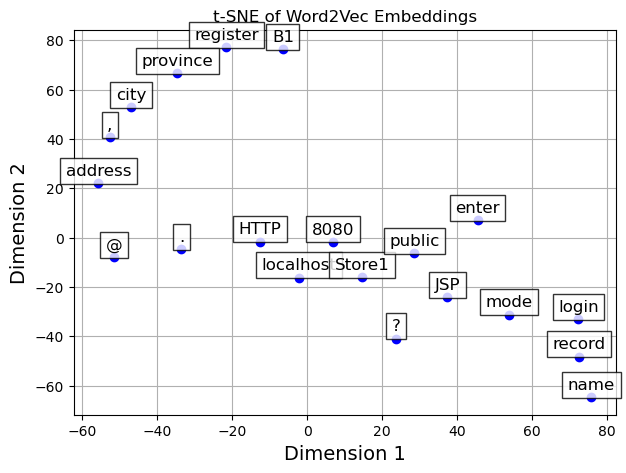

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from googletrans import Translator

number_of_words = 20

# Function to extract word vectors and words, limited to max_words
def get_word_vectors_and_labels(word2vec_model, max_words=20):
    words = list(word2vec_model.wv.index_to_key)[5:5 + number_of_words]
    vectors = np.array([word2vec_model.wv[word] for word in words])  # Convert to NumPy array
    return vectors, words

# Function to translate words to English
def translate_words(words, src_lang="es", dest_lang="en"):
    translator = Translator()
    translated_words = [translator.translate(word, src=src_lang, dest=dest_lang).text for word in words]
    return translated_words

# Perform t-SNE
def tsne_word2vec(vectors, n_components=2, random_state=42):
    tsne = TSNE(n_components=n_components, random_state=random_state, init='pca', perplexity=5)
    reduced_vectors = tsne.fit_transform(vectors)
    return reduced_vectors

# Plot t-SNE
def plot_tsne(reduced_vectors, words, title="t-SNE Visualization"):
    plt.figure(figsize=(7, 5))
    for i, word in enumerate(words):
        x, y = reduced_vectors[i]
        plt.scatter(x, y, marker='o', color='blue', zorder=4)
        # white box behind the text
        plt.text(x, y+5, word, fontsize=12, ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.8), zorder=5)
    plt.title(title)
    plt.xlabel("Dimension 1", fontsize=14)
    plt.ylabel("Dimension 2", fontsize=14)
    plt.grid(True)
    plt.show()

# Main
# Extract word vectors and words (maximum 20 words)
vectors, words = get_word_vectors_and_labels(word2vec_model, max_words=number_of_words)

# Perform t-SNE
reduced_vectors = tsne_word2vec(vectors)

# Translate words from Spanish to English
translated_words = translate_words(words)

# Plot the t-SNE visualization
plot_tsne(reduced_vectors, translated_words, title="t-SNE of Word2Vec Embeddings")

These words in the 2D space are clustered together based on their similarity in the high dimensional space, which is the word embedding space. We can see that words that are similar are clustered together. This is a good sign that the word embeddings are working as expected.

## Dendrogram of word embeddings

We can also create a dendrogram of the word embeddings to see how the words are clustered together using cosine similarity and hierarchical clustering.

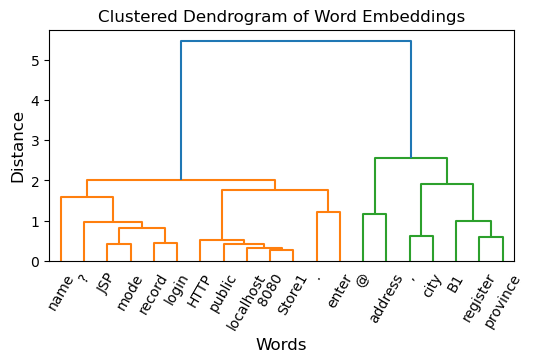

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics.pairwise import cosine_similarity

# Function to extract embeddings and compute cosine similarity
def get_cosine_similarity_matrix(word2vec_model, selected_words):
    word_vectors = np.array([word2vec_model.wv[word] for word in selected_words])
    similarity_matrix = cosine_similarity(word_vectors)
    return similarity_matrix

# Function to plot clustered dendrogram
def plot_dendrogram(similarity_matrix, words):
    # Convert similarity to a distance matrix (1 - similarity)
    distance_matrix = 1 - similarity_matrix
    # Perform hierarchical clustering
    linkage_matrix = linkage(distance_matrix, method='ward')
    # Plot dendrogram
    plt.figure(figsize=(6, 3))
    # translate words from Spanish to English
    words = translate_words(words)
    dendrogram(linkage_matrix, labels=words, leaf_rotation=60, leaf_font_size=10)
    plt.title("Clustered Dendrogram of Word Embeddings")
    plt.xlabel("Words", fontsize=12)
    plt.ylabel("Distance", fontsize=12)
    plt.show()

# Select words to analyze, sample the first 10 words
selected_words = list(word2vec_model.wv.index_to_key)[5:25]

# Compute similarity matrix
similarity_matrix = get_cosine_similarity_matrix(word2vec_model, selected_words)

# Plot dendrogram
plot_dendrogram(similarity_matrix, selected_words)

We can also use the dendrogram to see the hierarchical clustering of the words, where we see the same words clustered together (Using same words as in the t-SNE visualization).

### Indexing the word embeddings

We index the word embeddings to be able to better use them in the model

In [ ]:
# Create a word-to-index mapping
word_to_idx = {word: idx + 1 for idx, word in enumerate(word2vec_model.wv.index_to_key)}  # Start indexing from 1
word_to_idx['<UNK>'] = 0  # Add unknown token

vocab_size = len(word_to_idx)

### Embedding matrix

We can then create the embedding matrix for the model, where each row corresponds to a word in the vocabulary and each column corresponds to the word embedding.

In [ ]:
import numpy as np

# Prepare the embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in word_to_idx.items():
    if word in word2vec_model.wv:
        embedding_vector = word2vec_model.wv[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector


# Creating dataset for the model

We can then create the dataset for the model, where we pad the sequences to a maximum length of 1000 and use the word embeddings to represent the words in the sequences

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Define a dataset class for tokenized data
class URLDataset(Dataset):
    def __init__(self, data, word_to_idx, max_len=100): # 100 is a bit above average of 58
        self.data = data
        self.word_to_idx = word_to_idx
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        url_tokens = self.data.iloc[idx]['URL']
        label = self.data.iloc[idx]['classification']

        # Convert tokens to indices
        indices = [
            self.word_to_idx.get(word, self.word_to_idx['<UNK>'])  # Use <UNK> index for unknown words
            for word in url_tokens
        ]

        # Pad or truncate to max_len
        if len(indices) > self.max_len:
            indices = indices[:self.max_len]  # Truncate
        else:
            indices += [self.word_to_idx['<UNK>']] * (self.max_len - len(indices))  # Pad with <UNK>

        indices = torch.tensor(indices, dtype=torch.long)
        label = torch.tensor(label, dtype=torch.long)
        return indices, label

## TextCNN model architecture

We can then create the TextCNN model and train it on the training set, for this model we use the embedding matrix as the word embeddings, which is then fine-tuned during training. After this we use a convolutional layer with a window size of 2, 3, 4 and 5, with 128 filters for each window size. We then use a max pooling layer and then a binary classification layer.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the TextCNN model
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, filter_sizes=(2, 3, 4, 5), num_filters=64):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=0)
        # Initialize embedding layer with pre-trained embeddings
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = True  # Allow fine-tuning
        self.convs = nn.ModuleList([nn.Conv2d(1, num_filters, (filter_size, embedding_dim)) for filter_size in filter_sizes])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, 2)  # Assuming binary classification

    def forward(self, x):
        x = self.embedding(x)  # Shape: (batch_size, max_len, embedding_dim)
        x = x.unsqueeze(1)  # Shape: (batch_size, 1, max_len, embedding_dim)
        conved = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]
        pooled = [torch.max(conv, dim=2)[0] for conv in conved]
        cat = torch.cat(pooled, dim=1)
        output = self.fc(cat)
        return output

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device available for running:", device)

# Initialize the model
textcnn = TextCNN(vocab_size=vocab_size, embedding_dim=embedding_dim, embedding_matrix=embedding_matrix)
textcnn.to(device)

Device available for running: cuda


TextCNN(
  (embedding): Embedding(47786, 128, padding_idx=0)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(2, 128), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(3, 128), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(4, 128), stride=(1, 1))
    (3): Conv2d(1, 64, kernel_size=(5, 128), stride=(1, 1))
  )
  (fc): Linear(in_features=256, out_features=2, bias=True)
)

# Training the TextCNN model

We are now ready to train the TextCNN model

In [ ]:
import torch
import os

# Create Dataset and DataLoader for training data
train_dataset = URLDataset(train_data, word_to_idx)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create Dataset and DataLoader for validation data
val_dataset = URLDataset(val_data, word_to_idx)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(textcnn.parameters(), lr=0.001)

# Initialize lists to store losses
train_losses = []
val_losses = []

# Directory to save models
model_save_dir = "saved_models"
os.makedirs(model_save_dir, exist_ok=True)

# Training Loop
num_epochs = 15

textcnn.to(device)  # Move model to GPU if available

for epoch in range(num_epochs):
    total_loss = 0
    textcnn.train()  # Ensure model is in training mode

    # Training Phase
    for indices, labels in train_dataloader:
        indices, labels = indices.to(device), labels.to(device)  # Move tensors to GPU
        optimizer.zero_grad()
        outputs = textcnn(indices)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)

    # Validation Phase
    textcnn.eval()  # Set model to evaluation mode
    val_loss = 0
    with torch.no_grad():
        for val_indices, val_labels in val_dataloader:
            val_indices, val_labels = val_indices.to(device), val_labels.to(device)
            val_outputs = textcnn(val_indices)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    # Save the model for the current epoch
    model_path = os.path.join(model_save_dir, f"textcnn_epoch_{epoch + 1}.pth")
    torch.save(textcnn.state_dict(), model_path)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Model Saved: {model_path}')

print(f"All models are saved in: {model_save_dir}")

Epoch [1/15], Train Loss: 0.1685, Val Loss: 0.0591, Model Saved: saved_models\textcnn_epoch_1.pth
Epoch [2/15], Train Loss: 0.0053, Val Loss: 0.0264, Model Saved: saved_models\textcnn_epoch_2.pth
Epoch [3/15], Train Loss: 0.0011, Val Loss: 0.0251, Model Saved: saved_models\textcnn_epoch_3.pth
Epoch [4/15], Train Loss: 0.0008, Val Loss: 0.0239, Model Saved: saved_models\textcnn_epoch_4.pth
Epoch [5/15], Train Loss: 0.0006, Val Loss: 0.0243, Model Saved: saved_models\textcnn_epoch_5.pth
Epoch [6/15], Train Loss: 0.0002, Val Loss: 0.0249, Model Saved: saved_models\textcnn_epoch_6.pth
Epoch [7/15], Train Loss: 0.0005, Val Loss: 0.0237, Model Saved: saved_models\textcnn_epoch_7.pth
Epoch [8/15], Train Loss: 0.0005, Val Loss: 0.0273, Model Saved: saved_models\textcnn_epoch_8.pth
Epoch [9/15], Train Loss: 0.0004, Val Loss: 0.0321, Model Saved: saved_models\textcnn_epoch_9.pth
Epoch [10/15], Train Loss: 0.0001, Val Loss: 0.0253, Model Saved: saved_models\textcnn_epoch_10.pth
Epoch [11/15], Tra

## Loss plot of the TextCNN model

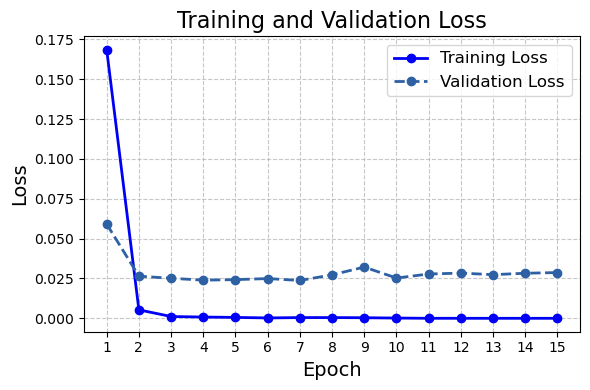

In [ ]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(6, 4))

# Plot training and validation loss, add points for each epoch
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='#0000f5', linewidth=2, marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='#2e60a4', linewidth=2, linestyle='--', marker='o')

# Customize axes and labels
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss', fontsize=16)
plt.xticks(range(1, num_epochs + 1), fontsize=10)  # Show all x-ticks
plt.yticks(fontsize=10)

# Add legend and gridlines
plt.legend(fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.7)

# Tight layout for IEEE style
plt.tight_layout()

# Save the plot
plt.savefig("training_validation_loss.pdf", dpi=300)  # Higher DPI for professional quality
plt.show()

We see that the loss of the model is decreasing, but for validation the loss seems to plateau a few epochs, this does show that the model is not overfitting to much.

# Load best model

We now pick the best model to be the one from epoch 7

In [ ]:
# load the best model
best_model_path = "saved_models/textcnn_epoch_7.pth"
textcnn.load_state_dict(torch.load(best_model_path))
textcnn.eval()

TextCNN(
  (embedding): Embedding(47786, 128, padding_idx=0)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(2, 128), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(3, 128), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(4, 128), stride=(1, 1))
    (3): Conv2d(1, 64, kernel_size=(5, 128), stride=(1, 1))
  )
  (fc): Linear(in_features=256, out_features=2, bias=True)
)

# Semantic feature extraction from TextCNN model

We can now extract the semantic features from the TextCNN model so we can use them in the next SVM classifier

In [ ]:
# Feature extraction function
def extract_textcnn_features(textcnn, data, word_to_idx):
    dataset = URLDataset(data.reset_index(drop=True), word_to_idx)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    textcnn.eval()
    features = []
    labels = []
    with torch.no_grad():
        for indices, label in dataloader:
            indices = indices.to(device)  # Move data to GPU
            outputs = textcnn.embedding(indices)
            x = outputs.unsqueeze(1)
            conved = [torch.relu(conv(x)).squeeze(3) for conv in textcnn.convs]
            pooled = [torch.max(conv, dim=2)[0] for conv in conved]
            feat = torch.cat(pooled, dim=1)
            features.append(feat.cpu().numpy())  # Move back to CPU for further processing
            labels.append(label.numpy())
    features = np.vstack(features)
    labels = np.hstack(labels)
    return features, labels

# Extract features for training, validation, and test sets
train_semantic_features, train_labels = extract_textcnn_features(textcnn, train_data, word_to_idx)
val_semantic_features, val_labels = extract_textcnn_features(textcnn, val_data, word_to_idx)
test_semantic_features, test_labels = extract_textcnn_features(textcnn, test_data, word_to_idx)

# Statistical feature extraction from preprocessed dataset

We also calculate the statistical features from the preprocessed dataset. Which are 'decoding_counts', 'illegal_keys', and 'illegal_values'.

In [ ]:
import re

def extract_key_value_pairs(tokens):
    key_value_pairs = {}
    # Logic to extract key-value pairs from tokens
    # This will depend on how your tokens are structured
    # For example, if tokens are ['key', '=', 'value', '&', 'key2', '=', 'value2']
    i = 0
    while i < len(tokens):
        if tokens[i].isalnum():
            key = tokens[i]
            if i + 2 < len(tokens) and tokens[i + 1] == '=' and tokens[i + 2]:
                value = tokens[i + 2]
                key_value_pairs[key] = value
                i += 3  # Move past 'key', '=', 'value'
            else:
                i += 1
        else:
            i += 1
    return key_value_pairs

def get_value_pattern(value):
    # Replace numbers with <NUM>, special chars with <SRC>, mixed with <STR>
    pattern = ''
    tokens = re.findall(r'\d+|[^\w\s]|[A-Za-z]+', value)
    for token in tokens:
        if token.isdigit():
            pattern += '<NUM>'
        elif token.isalpha():
            pattern += '<STR>'
        else:
            pattern += '<SRC>'
    return pattern

In [ ]:
# imports edit distance
from nltk.metrics import edit_distance

def extract_statistical_features(data, normal_keys_set, normal_value_patterns):
    features = []
    for index, row in data.iterrows():
        url_tokens = row['URL']
        decoding_counts = row['decoding_counts']  # Assuming you have computed this during preprocessing

        # Extract key-value pairs
        key_value_pairs = extract_key_value_pairs(url_tokens)

        # Illegal keys
        illegal_keys_count = 0
        for key in key_value_pairs.keys():
            if key not in normal_keys_set:
                # Calculate edit distance with normal keys
                min_edit_distance = min([edit_distance(key, normal_key) for normal_key in normal_keys_set])
                if min_edit_distance < 2:  # Threshold as per paper
                    illegal_keys_count += 1

        # Illegal values
        illegal_values_count = 0
        for key, value in key_value_pairs.items():
            value_pattern = get_value_pattern(value)
            if key in normal_value_patterns and value_pattern not in normal_value_patterns[key]:
                illegal_values_count += 1

        features.append([decoding_counts, illegal_keys_count, illegal_values_count])
    return np.array(features)

We then do the same for the training, validation and test sets

In [ ]:
from collections import defaultdict

# Build normal keys set and value patterns from training data
normal_train_data = train_data[train_data['classification'] == 0]
normal_keys_set = set()
normal_value_patterns = defaultdict(set)

for index, row in normal_train_data.iterrows():
    url_tokens = row['URL']
    key_value_pairs = extract_key_value_pairs(url_tokens)
    normal_keys_set.update(key_value_pairs.keys())
    for key, value in key_value_pairs.items():
        pattern = get_value_pattern(value)
        normal_value_patterns[key].add(pattern)

# Extract statistical features for training, validation, and test sets
train_statistical_features = extract_statistical_features(train_data, normal_keys_set, normal_value_patterns)
val_statistical_features = extract_statistical_features(val_data, normal_keys_set, normal_value_patterns)
test_statistical_features = extract_statistical_features(test_data, normal_keys_set, normal_value_patterns)

# Training and testing SVM model

Training and test the final Hybric combined SVC classifier model. We use the semantic features from the TextCNN model and the statistical features from the preprocessed dataset.

In [ ]:
# Combine features
train_combined_features = np.hstack((train_semantic_features, train_statistical_features))
val_combined_features = np.hstack((val_semantic_features, val_statistical_features))
test_combined_features = np.hstack((test_semantic_features, test_statistical_features))

# Train the SVM on the training set
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

svm = SVC(kernel='rbf', probability=True, C=1.0, gamma='scale')

print("Training the SVM...")
svm.fit(train_combined_features, train_labels)
print("SVM training complete.")

# Evaluate on the test set
y_test_pred = svm.predict(test_combined_features)
test_accuracy = accuracy_score(test_labels, y_test_pred)
test_precision = precision_score(test_labels, y_test_pred, average='weighted')
test_recall = recall_score(test_labels, y_test_pred, average='weighted')
test_f1 = f1_score(test_labels, y_test_pred, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

# Detailed classification report
print("\nTest Classification Report:")
print(classification_report(test_labels, y_test_pred))

Training the SVM...
SVM training complete.
Test Accuracy: 0.9982
Test Precision: 0.9982
Test Recall: 0.9982
Test F1-Score: 0.9982

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1864
           1       1.00      1.00      1.00      1520

    accuracy                           1.00      3384
   macro avg       1.00      1.00      1.00      3384
weighted avg       1.00      1.00      1.00      3384



We see that the model has a high accuracy of 0.99 on the test set. With a precision of 0.99, recall of 0.99 and F1 score of 0.99

## Confusion matrix

We can also create a confusion matrix to see how the model is performing

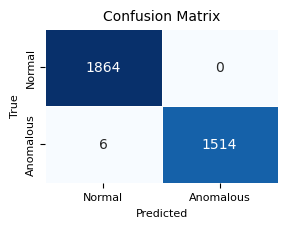

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(test_labels, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5)
plt.xlabel('Predicted', fontsize=8)
plt.ylabel('True', fontsize=8)
plt.title('Confusion Matrix', fontsize=10)
plt.xticks(ticks=[0.5, 1.5], labels=['Normal', 'Anomalous'], fontsize=8)
plt.yticks(ticks=[0.5, 1.5], labels=['Normal', 'Anomalous'], fontsize=8, rotation=90)

plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')  # Save with high DPI
plt.show()

We see that the model is performing very well, with only a few false positives and no false negatives

## ROC curve

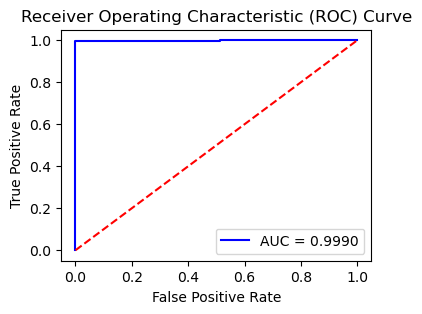

In [ ]:
# roc curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities
y_test_probs = svm.predict_proba(test_combined_features)[:, 1]
fpr, tpr, _ = roc_curve(test_labels, y_test_probs)

# Calculate AUC
auc = roc_auc_score(test_labels, y_test_probs)

# Plot ROC curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## PR curve

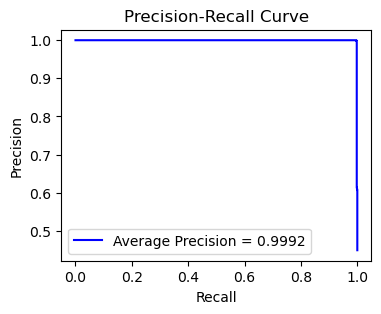

In [ ]:
# PR curve
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(test_labels, y_test_probs)
average_precision = average_precision_score(test_labels, y_test_probs)

# Plot PR curve
plt.figure(figsize=(4, 3))
plt.plot(recall, precision, color='blue', label=f'Average Precision = {average_precision:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Model only trained on semantic features

In [ ]:
# With only semantic features
svm = SVC(kernel='rbf', probability=True, C=1.0, gamma='scale')

print("Training the SVM...")
svm.fit(train_semantic_features, train_labels)
print("SVM training complete.")

# Evaluate on the test set
y_test_pred = svm.predict(test_semantic_features)
test_accuracy = accuracy_score(test_labels, y_test_pred)
test_precision = precision_score(test_labels, y_test_pred, average='weighted')
test_recall = recall_score(test_labels, y_test_pred, average='weighted')
test_f1 = f1_score(test_labels, y_test_pred, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

# Detailed classification report
print("\nTest Classification Report:")
print(classification_report(test_labels, y_test_pred))

Training the SVM...
SVM training complete.
Test Accuracy: 0.9982
Test Precision: 0.9982
Test Recall: 0.9982
Test F1-Score: 0.9982

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1864
           1       1.00      1.00      1.00      1520

    accuracy                           1.00      3384
   macro avg       1.00      1.00      1.00      3384
weighted avg       1.00      1.00      1.00      3384



In [ ]:
# show me a semantic feature and a statistical feature
print("Semantic Feature:")
print(train_semantic_features[0])
print("\nStatistical Feature:")
print(train_statistical_features[0])

Semantic Feature:
[0.         0.         1.9211733  0.         2.9419792  0.
 0.5690233  2.062673   0.         0.         1.4622031  1.9911659
 0.         0.07955816 0.         4.1683555  0.49875307 0.
 2.7999365  3.7771895  0.         3.5563824  0.         2.062141
 0.         0.         3.194212   0.38831294 1.4761919  0.
 1.4254982  0.         0.         3.2434993  0.         0.
 0.         0.         0.3432288  0.         0.         0.
 0.         0.9388422  1.7466178  1.191193   0.         0.
 2.1826577  0.17578635 3.1585543  0.         1.5825014  0.
 0.         0.         0.         0.         0.12814432 1.9562179
 2.8978174  0.12468135 0.04403436 0.         2.3132875  0.13095996
 0.37188718 0.         0.         2.52571    0.8443131  0.
 0.         0.7001301  0.         3.2327056  0.         0.
 2.7438283  0.3463938  1.1176941  0.         0.70380235 0.83156246
 0.         1.8217038  3.6986933  0.         0.         0.
 0.         0.57347137 0.         0.         2.4920454  0.
 1

In [ ]:
svm_stat_only = SVC(kernel='rbf', probability=True)
svm_stat_only.fit(train_statistical_features, train_labels)
predictions_stat_only = svm_stat_only.predict(test_statistical_features)
print("Accuracy with only statistical features:", accuracy_score(test_labels, predictions_stat_only))

Accuracy with only statistical features: 0.8031914893617021
